# Hierarchical Inference of ∆F

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 


In [190]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import mut.viz
import mut.stats
import mut.thermo
constants = mut.thermo.load_constants()
colors = mut.viz.personal_style()
%load_ext stanmagic

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In [55]:
data = pd.read_csv('../../data/csv/compiled_data.csv')
# data = data[data['mutant'] != 'wt']
data.dropna(inplace=True)

In [ ]:
#         theo_bohr[i] = -log(1 + exp(-ep_AI) * ((1 + c[i]./Ki) / (1 + c[i]./Ka))^n_sites) + log(R[i] ./ n_ns) - ep_RA[i];
#         delta_bohr[i] = theo_bohr[i] - empirical_bohr[i];

In [285]:
%%stan -v hier_F

data {
    // Dimensional Parameters
    int<lower=1> N; // Total number of measurements
    int<lower=1> J; // Total number of unique samples.
    int<lower=1, upper=J> idx[N];  
    
    // Parameters for calculation of F
    vector[J] ep_RA;
    vector<lower=0>[J] R;
    vector<lower=0>[J] c;
    real<lower=0> n_ns;
    real<lower=0> Ka;
    real<lower=0> Ki;
    real ep_AI;
    int<lower=1> n_sites;
     
    // Defined the observed data
    vector[N] obs_fc; // Observed fold-change in gene expression
}

transformed data {
    real theo_bohr[J];
    for (i in 1:J) {
    theo_bohr[i] = log(1 ./ (1 + exp(-ep_AI) * ((1 + c[i]/Ki) ./ (1 + c[i]/Ka))^n_sites)) + log(R[i] ./ n_ns) - ep_RA[i];
    }
}

parameters {
    vector<lower=0, upper=1>[J] mu_fc; // Mean fold_change for each unique sample
    real<lower=0> sigma_fc; // Standard deviation for each sample
}

model {
    mu_fc ~ uniform(0, 1);
    sigma_fc ~ normal(0, 0.1);
    obs_fc ~ normal(mu_fc[idx], sigma_fc); 
}

generated quantities {
    real empirical_bohr[J]; 
    real delta_bohr[J];
    for (i in 1:J) {
        empirical_bohr[i] = log((1 / mu_fc[i]) - 1);
        delta_bohr[i] = theo_bohr[i] - empirical_bohr[i];
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in hier_F object.
Type hier_F in a cell to see a nicely formatted code output in a notebook
     ^^^^^^
Access model compile output properties
hier_F.model_file -> Name of stan_file [None]
hier_F.model_name -> Name of stan model [None]
hier_F.model_code -> Model code [ data {     // Dimen ....]


In [286]:
model = pystan.StanModel(model_code=hier_F.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e19db5c00d94085c5bbc7746432fa910 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpsfi1t6b7/stanfit4anon_model_e19db5c00d94085c5bbc7746432fa910_3722580124100362655.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [287]:
# Assign identififers. 
dfs = []
grouped = data.groupby(['class', 'mutant', 'repressors', 'operator', 'IPTGuM'])
_idx = 1
idx_map = {}
for g, d in grouped:
    d = d.copy()
    d['idx'] = _idx
    dfs.append(d)
    idx_map[_idx] = g
    _idx += 1

ep_RA = np.array([constants[g[1]] for g, _ in _data.groupby(['idx', 'operator'])]) 
_data = pd.concat(dfs, sort=False)
# Generate data dict
data_dict = {'N': len(_data), 
             'J':np.max(_data['idx']),
             'idx':_data['idx'].astype(int),
             'obs_fc': _data['fold_change'],
             'ep_RA': ep_RA,
             'n_sites': constants['n_sites'],
             'ep_AI': constants['ep_AI'],
             'R': _data.groupby('idx')['repressors'].mean(),
             'Ka': constants['Ka'],
             'Ki': constants['Ki'],
             'c':_data.groupby(['idx'])['IPTGuM'].mean(),
             'n_ns':constants['Nns']}

samples = model.sampling(data_dict)

Text(0, 0.5, '∆F')

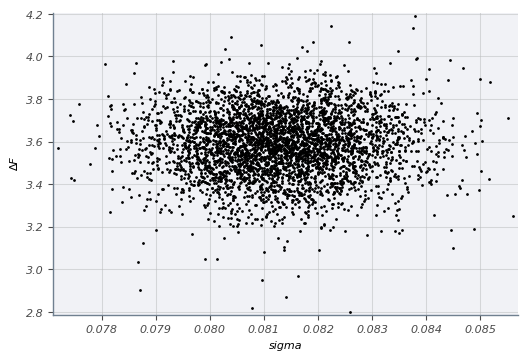

In [291]:
samples_df = samples.to_dataframe()
fig, ax = plt.subplots()
for g, d in samples_df.groupby(['divergent__']):
    if g == 0:
        color = 'k'
    else:
        color = 'r'
    ax.plot(d['sigma_fc'], d['delta_bohr[1]'], '.', ms=2, color=color)
    
ax.set_xlabel('sigma')
ax.set_ylabel('∆F')

In [292]:
stat_df = pd.DataFrame()
ind = np.argmax(samples_df['lp__'].values)
mode_loc = samples_df.iloc[ind]
for g, d in _data.groupby('idx'):
    fc_hpd = mut.stats.compute_hpd(samples_df[f'mu_fc[{g}]'], 0.95)
    bohr_hpd = mut.stats.compute_hpd(samples_df[f'empirical_bohr[{g}]'], 0.95)
    delta_bohr_hpd = mut.stats.compute_hpd(samples_df[f'delta_bohr[{g}]'], 0.95)
    _mapper = {'repressors':d['repressors'].unique()[0],
              'mutant': d['mutant'].unique()[0],
              'operator':d['operator'].unique()[0],
              'IPTGuM': d['IPTGuM'].unique()[0],
              'class': d['class'].unique()[0],
              'fc_mu_mode': mode_loc[f'mu_fc[{g}]'],
              'fc_mu_min': fc_hpd[0],
              'fc_mu_max': fc_hpd[1],
              'empirical_F': mode_loc[f'empirical_bohr[{g}]'],
              'empirical_F_min': bohr_hpd[0],
              'empirical_F_max': bohr_hpd[1],
              'delta_F': mode_loc[f'delta_bohr[{g}]'],
              'delta_F_min': delta_bohr_hpd[0],
              'delta_F_max': delta_bohr_hpd[1] 
              }  
    stat_df = stat_df.append(_mapper, ignore_index=True)

In [293]:
stat_df.to_csv('../../data/csv/hierarchical_F_foldchange_stats.csv', index=False)

## Exploring the results

In [294]:
DNA_muts = stat_df[((stat_df['class']=='DNA') | (stat_df['class']=='WT'))]

(-0.15, 1.15)

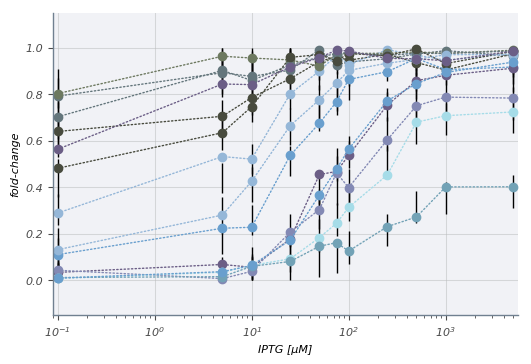

In [298]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')

for g, d in DNA_muts.groupby(['mutant', 'repressors', 'operator']):
    ax.errorbar(d['IPTGuM'], d['fc_mu_mode'], fmt='o', lw=1, linestyle=':', label=g)
    ax.vlines(d['IPTGuM'], d['fc_mu_min'], d['fc_mu_max'], lw=1)
# ax.legend()

ax.set_ylim([-0.15, 1.15])

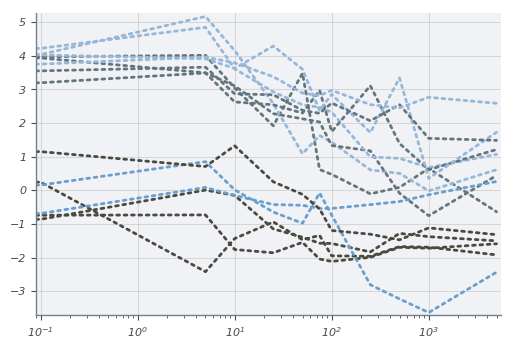

In [299]:
color = {m:colors[i] for i, m in enumerate(DNA_muts['mutant'].unique())}
for g, d in DNA_muts.groupby(['repressors', 'mutant', 'operator']):
    plt.semilogx(d['IPTGuM'], d['delta_F'], ':', label=g, color=color[g[1]])
#     plt.vlines(d['IPTGuM'], d['delta_F_min'], d['delta_F_max'], color=color[g])
    

# plt.legend()

In [ ]:
DNA_muts['empirical_F_min']